In [1]:
from collections import defaultdict
import json
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.collections import LineCollection, PatchCollection
import matplotlib.patches as mpatches
import numpy as np
import os
import pandas as pd
import seaborn as sns
import sys

%matplotlib inline

In [2]:
os.getcwd()

'/Users/jlhudd/projects/nextstrain/flu-forecasting/analyses/projected-frequencies'

In [3]:
project_path = os.path.dirname(os.path.dirname(os.getcwd()))
augur_path = os.path.join(project_path, "dist", "augur")

In [4]:
sys.path.append(augur_path)

In [5]:
from base.fitness_model import fitness_model as FitnessModel
from base.frequencies import KdeFrequencies
from base.io_util import json_to_tree

In [63]:
stem = "2006-2018y_10v_titers"
stem = "2006-2018y_30v_1"
stem_pieces = stem.split("_")
year_range = stem_pieces[0].replace("y", "")
num_viruses = stem_pieces[1].replace("v", "")
sample_number = stem_pieces[2]

tree_path = "%s/dist/augur/builds/flu/auspice/flu_h3n2_ha_%s_tree.json" % (project_path, stem)
frequencies_path = "%s/frequencies/flu_h3n2_ha_%s.json" % (project_path, stem)
model_path = "%s/models/%s/%s/ep/%s.json" % (project_path, year_range, num_viruses, sample_number)

In [64]:
model_path

'/Users/jlhudd/projects/nextstrain/flu-forecasting/models/2006-2018/30/ep/1.json'

In [65]:
def load_tree_from_json_filename(filename):
    # Load JSON tree.
    with open(filename, "r") as json_fh:
         json_tree = json.load(json_fh)

    # Convert JSON tree layout to a Biopython Clade instance.
    tree = json_to_tree(json_tree)

    return tree

def load_frequencies_from_json_filename(filename):
    # Load JSON frequencies.
    with open(filename, "r") as json_fh:
         json_frequencies = json.load(json_fh)

    # Create frequencies instance from JSON.
    frequencies = KdeFrequencies.from_json(json_frequencies)

    return frequencies

def project_clade_frequencies_by_delta_from_time(tree, model, time, delta, delta_steps_per_year=12):
    """
    Project clade frequencies from a given time to the future by a given delta.
    """
    # Calculate the steps between the projection date and delta time into the
    # future. First, find the frequency pivot that is closest to the requested
    # projection date.
    max_date = model.timepoints[np.searchsorted(model.timepoints, time)]
    future_date = max_date + delta

    # Then, calculate a fixed number of steps between that pivot and delta time
    # into the future.
    projected_pivots = np.linspace(max_date, future_date, int(delta_steps_per_year * delta))
    deltas = projected_pivots - max_date

    # Identify tip predictors and frequencies at the current time point.
    all_pred = model.predictor_arrays[max_date]
    all_freqs = model.freq_arrays[max_date]

    # For each requested delta, project current tip frequencies using the model
    # and calculate the corresponding projected clade frequencies.
    projected_clade_frequencies = defaultdict(list)

    for delta in deltas:
        # Project all tip frequencies.
        pred_freq = model.projection(model.model_params, all_pred, all_freqs, delta)

        # Normalize projected frequencies.
        pred_freq = pred_freq / pred_freq.sum()

        # Store projected frequencies by clade id.
        for i, tip in enumerate(model.tips):
            projected_clade_frequencies[tip.clade].append(pred_freq[i])

        # Calculate projected frequencies for internal nodes and store by clade it.
        for node in tree.find_clades(order="postorder"):
            if not node.is_terminal():
                projected_clade_frequencies[node.clade].append(pred_freq[node.tips].sum())

    projected_frequencies = {
        "params": {
            "max_date": max_date
        },
        "data": {
            "pivots": projected_pivots.tolist(),
            "frequencies": projected_clade_frequencies
        }
    }

    return projected_frequencies

In [66]:
tree = load_tree_from_json_filename(tree_path)

In [67]:
tree

Clade(branch_length=0, clade=0, name='NODE_0003831', numdate=2004.86689231, strain='NODE_0003831', tvalue=0.0, xvalue=0.0, yvalue=3743.18848)

In [68]:
frequencies = load_frequencies_from_json_filename(frequencies_path)

In [69]:
frequencies

In [111]:
#frequencies.sigma_narrow = 0.33

In [112]:
#frequencies.proportion_wide = 0.0

In [113]:
#f = frequencies.estimate(tree)

In [114]:
#frequencies.proportion_wide

0.0

## Plot observed frequencies

In [115]:
clades = [node for node in tree.get_nonterminals() if len(node.get_terminals()) > 50]

In [116]:
len(clades)

277

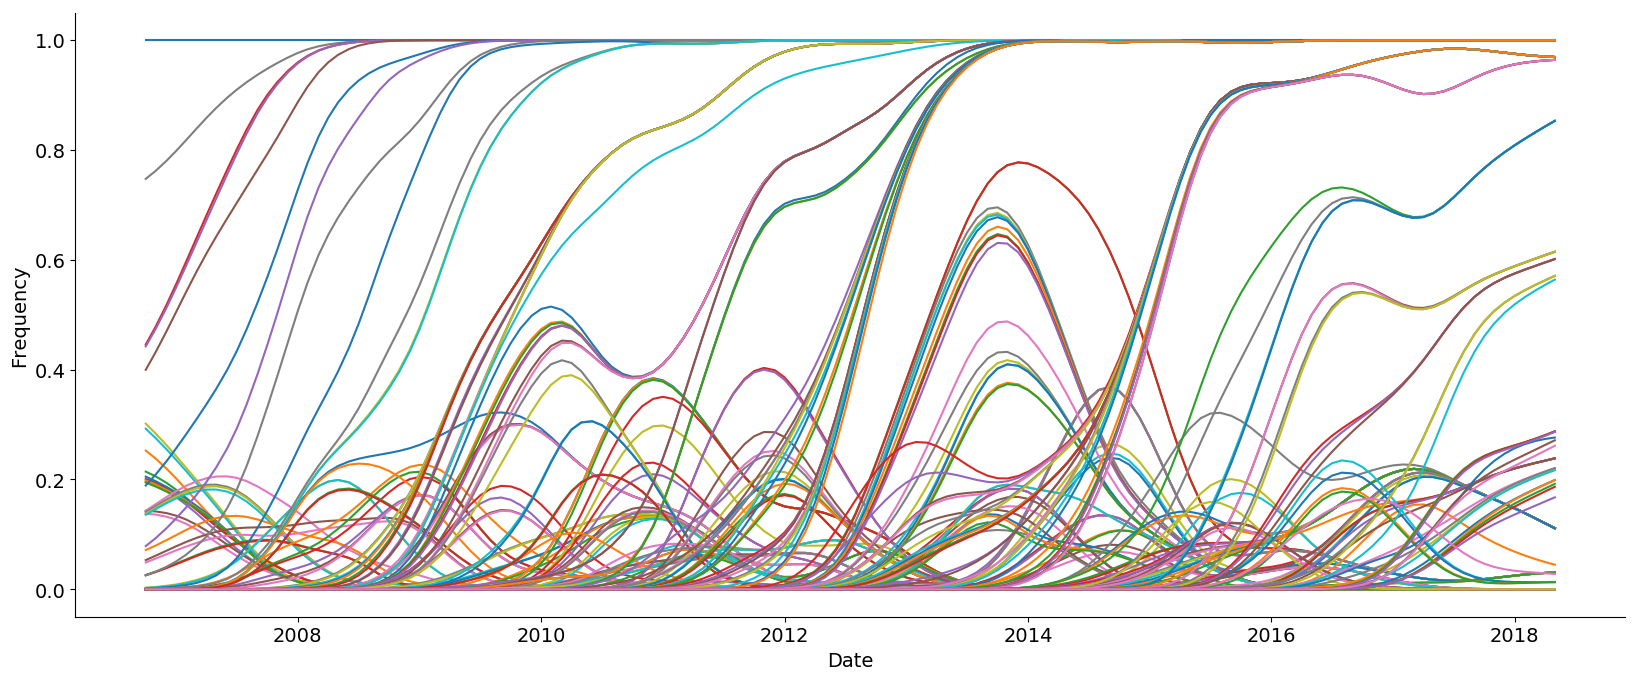

In [117]:
fig, axes = plt.subplots(1, 1, figsize=(20, 8), sharex=False, sharey=True,
                         squeeze=False, gridspec_kw={"hspace": 0.5})
flat_axes = axes.flatten()
#random_clades = np.random.choice(clades, size=number_of_clades)
ax = flat_axes[0]

for clade in clades:
    ax.plot(frequencies.pivots, frequencies.frequencies[clade.clade], "-")

#ax.set_xlim(2008, 2012)
ax.set_xlabel("Date")
ax.set_ylabel("Frequency")

ax.legend()
sns.despine()

## Project frequencies

In [75]:
with open(model_path, "r") as fh:
    json_model = json.load(fh)

predictors = {record["predictor"]: [round(record["param"], 2), round(record["global_sd"], 2)]
              for record in json_model["params"]}
predictors_key = "-".join(sorted([record["predictor"] for record in json_model["params"]]))
predictor_kwargs = json_model["predictor_kwargs"]

model = FitnessModel(
    tree,
    frequencies,
    predictors,
    epitope_masks_fname="%s/builds/flu/metadata/ha_masks.tsv" % augur_path,
    epitope_mask_version="wolf",
    tolerance_mask_version="HA1",
    min_freq=0.1,
    predictor_kwargs=predictor_kwargs
)
model.prep_nodes()
model.delta_time = json_model["delta_time"]

predictor_arrays = {}
for key in json_model["predictor_arrays"]:
    predictor_arrays[float(key)] = np.array(json_model["predictor_arrays"][key])

model.predictor_arrays = predictor_arrays

freq_arrays = {}
for key in json_model["freq_arrays"]:
    freq_arrays[float(key)] = np.array(json_model["freq_arrays"][key])

model.freq_arrays = freq_arrays

model.select_clades_for_fitting()

setup wolf epitope mask and HA1 tolerance mask


In [76]:
model.timepoints

array([ 2007.25,  2007.76,  2008.26,  2008.77,  2009.27,  2009.77,
        2010.28,  2010.78,  2011.29,  2011.79,  2012.29,  2012.8 ,
        2013.3 ,  2013.81,  2014.31,  2014.81,  2015.32,  2015.82,
        2016.33,  2016.83,  2017.33,  2018.33])

In [77]:
time = 2013.3
frequency_params = frequencies.get_params()
frequency_params["max_date"] = time
censored_frequencies = KdeFrequencies(**frequency_params)
censored = censored_frequencies.estimate(tree)

In [78]:
projected_frequencies = project_clade_frequencies_by_delta_from_time(tree, model, time, delta=1.0)

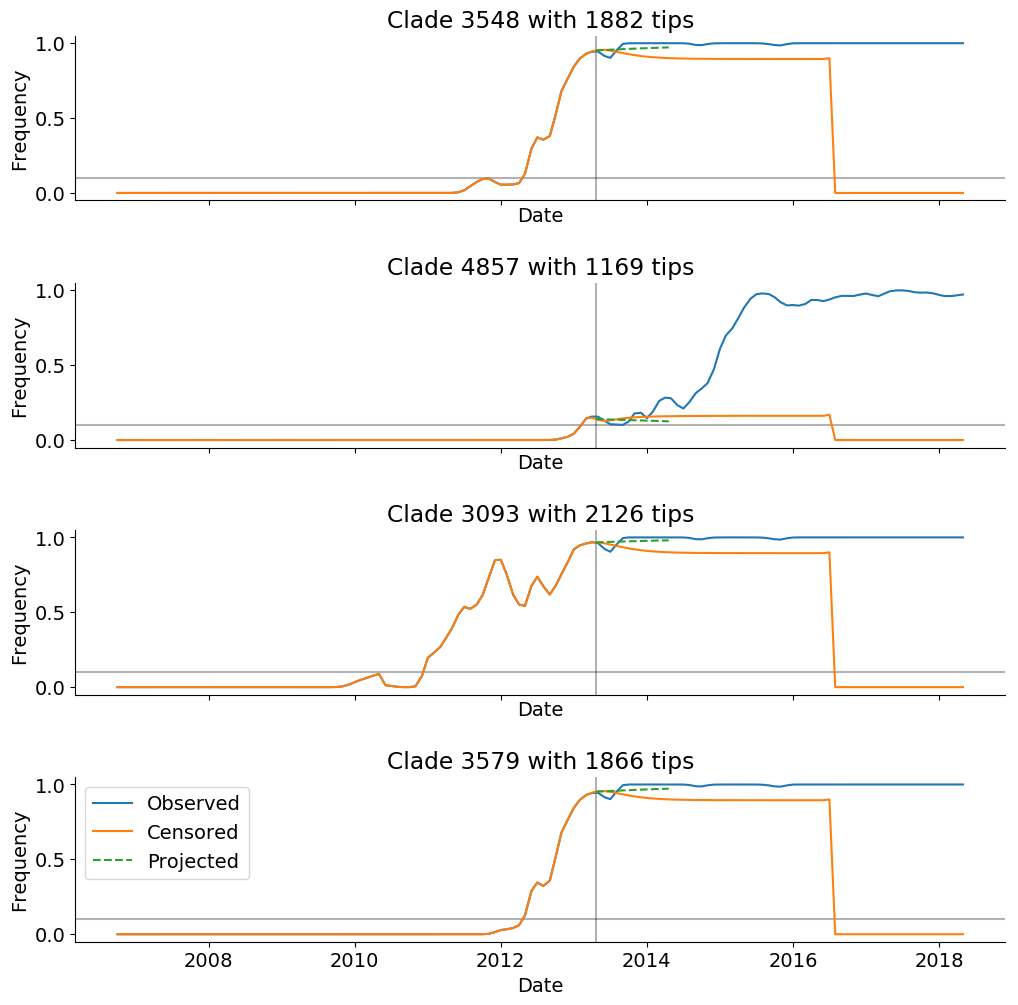

In [79]:
number_of_clades = 4
fig, axes = plt.subplots(number_of_clades, 1, figsize=(12, 3 * number_of_clades), sharex=True, sharey=True,
                         squeeze=False, gridspec_kw={"hspace": 0.5})
flat_axes = axes.flatten()
random_clades = np.random.choice(model.fit_clades[time], size=number_of_clades)

for i, clade in enumerate(random_clades):
    ax = flat_axes[i]
    ax.set_title("Clade %s with %s tips" % (clade.clade, len(clade.get_terminals())))
    ax.plot(model.pivots, frequencies.frequencies[clade.clade], "-",
            label="Observed")
    ax.plot(model.pivots, censored_frequencies.frequencies[clade.clade], "-",
            label="Censored")
    ax.plot(projected_frequencies["data"]["pivots"], projected_frequencies["data"]["frequencies"][clade.clade], "--",
            label="Projected")

    ax.axhline(y=0.1, color="#000000", alpha=0.3, zorder=-10)
    ax.axvline(x=time, color="#000000", alpha=0.3, zorder=-10)

    #ax.set_xlim(2008, 2012)
    ax.set_xlabel("Date")
    ax.set_ylabel("Frequency")

ax.legend()
sns.despine()

In [80]:
model.model_params

array([ 0.16])

## Plot fitness on the tree

In [81]:
tree

Clade(branch_length=0, clade=0, name='NODE_0003831', numdate=2004.86689231, strain='NODE_0003831', tvalue=0.0, xvalue=0.0, yvalue=3743.18848)

In [120]:
def plot_tree(tree, model, timepoint, color_by_trait, initial_branch_width, tip_size, figure_name=None):
    """Plot a BioPython Phylo tree in the BALTIC-style.
    """
    # Tips being fit at this timepoint by clade id.
    tips_being_fit = set()
    for clade in model.fit_clades[timepoint]:
        for tip in clade.get_terminals():
            tips_being_fit.add(tip.clade)
    
    # Plot H3N2 tree in BALTIC style from Bio.Phylo tree.
    mpl.rcParams['savefig.dpi'] = 120
    mpl.rcParams['figure.dpi'] = 100

    mpl.rcParams['font.weight']=300
    mpl.rcParams['axes.labelweight']=300
    mpl.rcParams['font.size']=14

    yvalues = [node.yvalue for node in tree.find_clades()]
    y_span = max(yvalues)
    y_unit = y_span / float(len(yvalues))

    # Setup colors.
    trait_name = color_by_trait
    traits = [k.attr[trait_name] for k in tree.get_terminals()]
    norm = mpl.colors.Normalize(-1 * np.std(traits), np.std(traits))
    cmap = mpl.cm.viridis

    #
    # Setup the figure grid.
    #

    fig = plt.figure(figsize=(30, 22), facecolor='w')
    gs = gridspec.GridSpec(2, 1, height_ratios=[30, 1], width_ratios=[1], hspace=0.1, wspace=0.1)
    ax = fig.add_subplot(gs[0])
    colorbar_ax = fig.add_subplot(gs[1])

    L=len([k for k in tree.find_clades() if k.is_terminal()])

    # Setup arrays for tip and internal node coordinates.
    tip_circles_x = []
    tip_circles_y = []
    tip_circles_color = []
    tip_circle_sizes = []
    node_circles_x = []
    node_circles_y = []
    node_circles_color = []
    node_line_widths = []
    node_line_segments = []
    node_line_colors = []
    branch_line_segments = []
    branch_line_widths = []
    branch_line_colors = []
    branch_line_labels = []

    for k in tree.find_clades(): ## iterate over objects in tree
        x=k.attr["num_date"] ## or from x position determined earlier
        y=k.yvalue ## get y position from .drawTree that was run earlier, but could be anything else

        if k.up is None:
            xp = None
        else:
            xp=k.up.attr["num_date"] ## get x position of current object's parent

        if x==None: ## matplotlib won't plot Nones, like root
            x=0.0
        if xp==None:
            xp=x

        c = (0.7, 0.7, 0.7)
        # Only show colors for nodes sampled prior to the current timepoint.
        # Only show colors for nodes if they were in a clade that was being fit
        # at this timepoint.
        if k.attr["num_date"] <= timepoint and k.attr.has_key(trait_name) and k.clade in tips_being_fit:
            c = cmap(norm(k.attr[trait_name]))

        branchWidth=2
        if k.is_terminal(): ## if leaf...
            s = tip_size ## tip size can be fixed

            tip_circle_sizes.append(s)
            tip_circles_x.append(x)
            tip_circles_y.append(y)
            tip_circles_color.append(c)
        else: ## if node...
            k_leaves = [child
                        for child in k.find_clades()
                        if child.is_terminal()]

            # Scale branch widths by the number of tips.
            branchWidth += initial_branch_width * len(k_leaves) / float(L)

            if len(k.clades)==1:
                node_circles_x.append(x)
                node_circles_y.append(y)
                node_circles_color.append(c)

            ax.plot([x,x],[k.clades[-1].yvalue, k.clades[0].yvalue], lw=branchWidth, color="#cccccc", ls='-', zorder=9, solid_capstyle='round')

        branch_line_segments.append([(xp, y), (x, y)])
        branch_line_widths.append(branchWidth)
        
        # Highlight branches of clades that are being fit at the given timepoint.
        if k in model.fit_clades[timepoint]:
            branch_line_colors.append("#00ff00")
        else:
            branch_line_colors.append("#cccccc")

    branch_lc = LineCollection(branch_line_segments, zorder=9)
    branch_lc.set_color(branch_line_colors)
    branch_lc.set_linewidth(branch_line_widths)
    branch_lc.set_label(branch_line_labels)
    branch_lc.set_linestyle("-")
    ax.add_collection(branch_lc)

    # Add circles for tips and internal nodes.
    tip_circle_sizes = np.array(tip_circle_sizes)
    ax.scatter(tip_circles_x, tip_circles_y, s=tip_circle_sizes, facecolor=tip_circles_color, edgecolor='none',zorder=11) ## plot circle for every tip
    ax.scatter(tip_circles_x, tip_circles_y, s=tip_circle_sizes*2, facecolor='k', edgecolor='none', zorder=10) ## plot black circle underneath
    ax.scatter(node_circles_x, node_circles_y, facecolor=node_circles_color, s=50, edgecolor='none', zorder=10, lw=2, marker='|') ## mark every node in the tree to highlight that it's a multitype tree

    # Grey out the time after the current timepoint + delta.
    delta_timepoint = timepoint + model.delta_time
    rectangle = plt.Rectangle((delta_timepoint, 0), model.timepoints[-1] - delta_timepoint, y_span, fc='#999999',
                              alpha=0.2)
    ax.add_patch(rectangle)

    # Highlight the time between the current timepoint and the future timepoint.
    rectangle = plt.Rectangle((timepoint, 0), model.delta_time, y_span, fc='#ff0000',
                              alpha=0.2)
    ax.add_patch(rectangle)

    ax.spines['top'].set_visible(False) ## no axes
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)

    ax.set_xticks(model.timepoints)
    ax.grid(axis='x',ls='-',color='grey')
    ax.tick_params(axis='y',size=0)
    ax.set_yticklabels([])
    
    ax.set_title("Timepoint: %s to %s" % (timepoint, delta_timepoint))

    cb1 = mpl.colorbar.ColorbarBase(
        colorbar_ax,
        cmap=cmap,
        norm=norm,
        orientation='horizontal'
    )
    cb1.set_label(color_by_trait)

    gs.tight_layout(fig)
    
    if figure_name:
        plt.savefig(figure_name)
        plt.close()

In [121]:
timepoint = model.timepoints[13]

In [122]:
timepoint

2013.8099999999999

In [123]:
#timepoints = model.timepoints[:-1]
timepoints = [model.timepoints[13]]

Plotting 2013.81


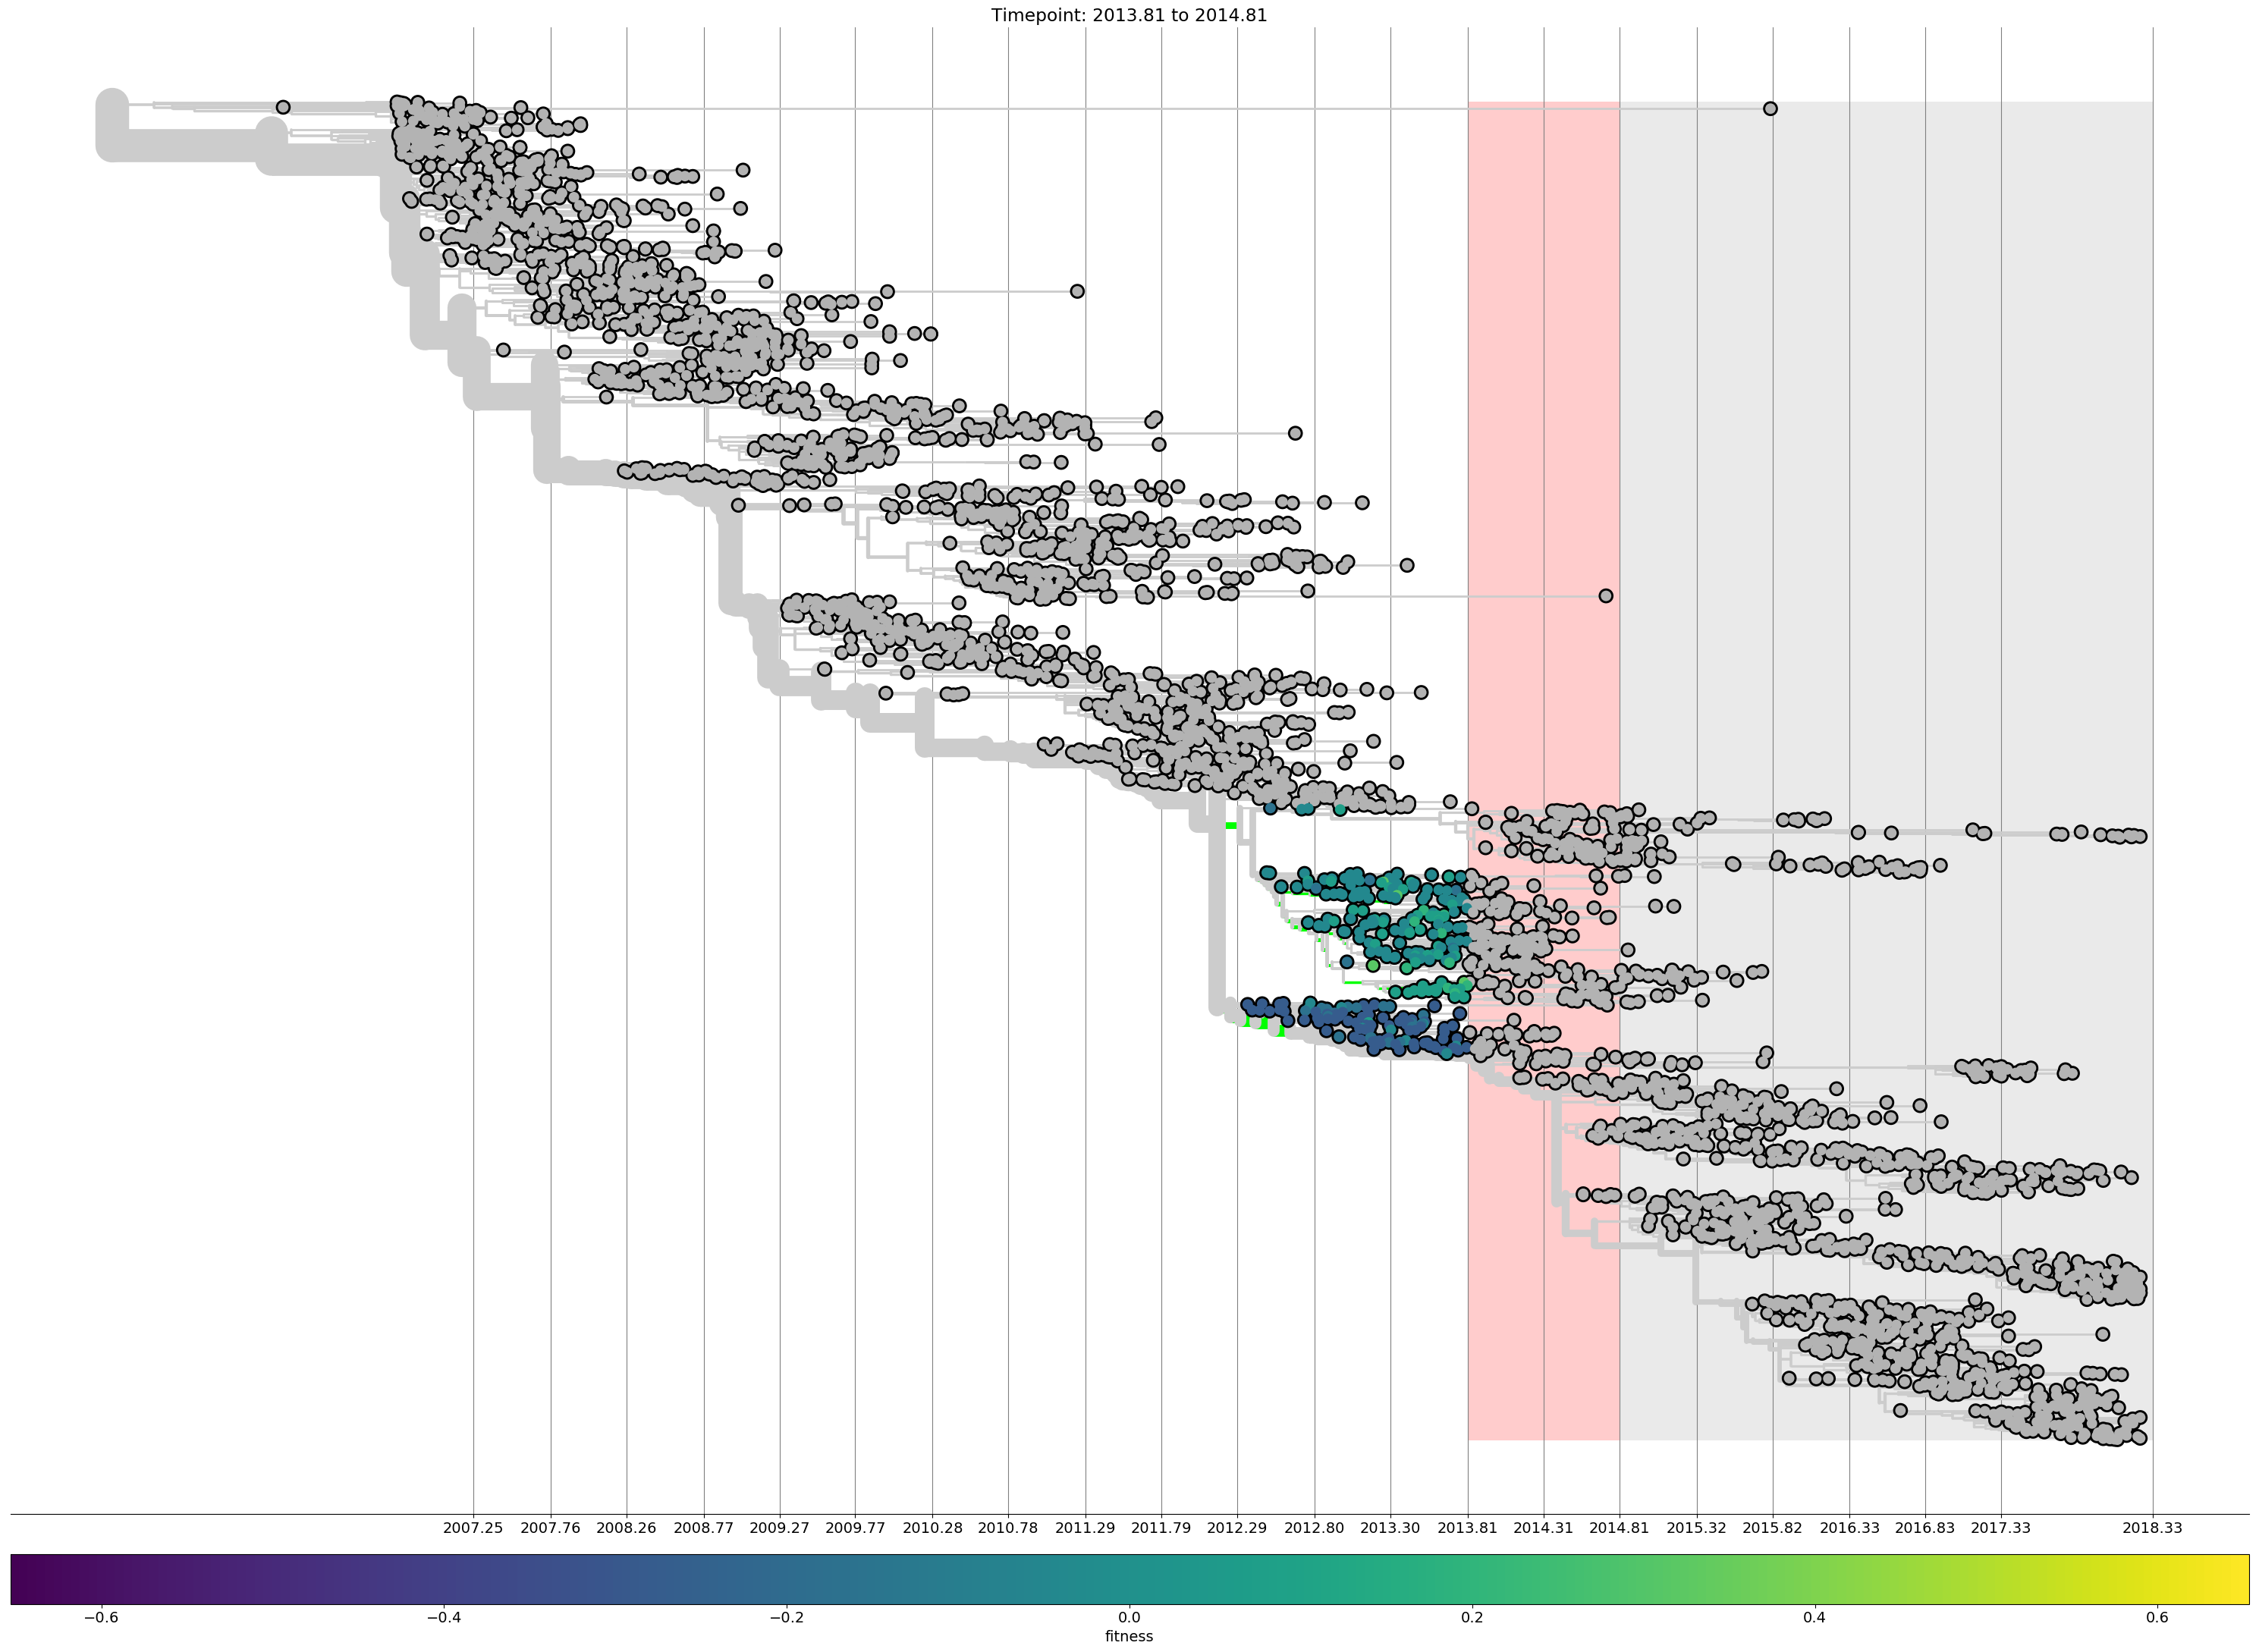

In [124]:
for timepoint in timepoints:
    print("Plotting %s" % timepoint)
    # Assign standardized predictor fitness value.
    for tip in tree.get_terminals():
        index = model.tips.index(tip)
        tip.attr["fitness"] = model.fitness(model.model_params, model.predictor_arrays[timepoint][index])
        #tip.attr["fitness"] = model.predictor_arrays[timepoint][index][0]

    plot_tree(
        tree,
        model,
        timepoint,
        color_by_trait="fitness",
        initial_branch_width=30.0,
        tip_size=100.0
        #figure_name="fitness_tree_%s_%s_%s.png" % (stem, "-".join(model.predictors), timepoint)
    )